In [109]:
import os
import util
import shutil
import random
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

from CNN import CNN
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.layers.experimental import preprocessing

In [110]:
# Check for any available GPU to utilize during training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


In [111]:
# Project Paths
_ROOT_DIR = os.path.dirname(pathlib.Path.cwd())
_DATASET_DIRECTORY_PATH = _ROOT_DIR+'/data/speech_commands'
_PATH_TO_RESULTS = _ROOT_DIR+'/results'
_PATH_TO_MODEL = _PATH_TO_RESULTS+'/model/'
_PATH_TO_NOISE_SRC = [os.path.join(_DATASET_DIRECTORY_PATH+'/_background_noise_', name)
                            for name in os.listdir(_DATASET_DIRECTORY_PATH+'/_background_noise_') if name.endswith('.wav')]

# Settings
_SAMPLE_RATE = 16000
_DATASET_SPLIT = (0.7, 0.2, 0.1)
_WORDS = ['unknown', 'silence', 'yes', 'no', 'up',
          'down', 'left', 'right', 'on', 'off', 'stop', 'go']

_BATCH_SIZE = 100
_EPOCHS = 10
_LEARNING_RATE = 1e-3
_DROPOUT = 0.2

### Download, extract and partition data into datasets for training, validation and testing

In [112]:
# Check if dataset directory already exist, otherwise download, extract and remove the archive
if not os.path.isdir(_DATASET_DIRECTORY_PATH):
    print('Downloading from ' + _DOWNLOAD_URL)
    util.download_file(_DOWNLOAD_URL, _ROOT_DIR+'/data/speech_commands.tar.gz')
    print("Extracting archive...")
    shutil.unpack_archive(
        _ROOT_DIR+'/data/speech_commands.tar.gz', _DATASET_DIRECTORY_PATH)
    os.remove('data/speech_commands.tar.gz')
    print("Done.")

    # Create samples for the 'silence' category using the _background_noises_ recordings
    silence_samples = random.randint(1500, 4000)
    util.generateSilenceSamples(silence_samples, _DATASET_DIRECTORY_PATH)

In [113]:
data_dir = pathlib.Path(_DATASET_DIRECTORY_PATH)
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = [filename for filename in filenames if not '_background_noise_' in filename]
filenames = tf.random.shuffle(filenames)

train_samples = int(len(filenames) * _DATASET_SPLIT[0])
val_samples = int(len(filenames) * _DATASET_SPLIT[1])

train, remainder = filenames[:train_samples], filenames[train_samples:]
val, test = remainder[:val_samples], remainder[val_samples:]


### Declare methods for loading, preprocessing and augmentating data

In [114]:
def decode_audio(audio_binary):
    """Decodes a 16-bit WAV file to a float tensor, values scaled between -1.0 and 1.0

    Args:
        audio_binary (tf.Tensor[string]): [description] The WAV-encoded audio from a file.
    Returns:
        [tf.Tensor[float]]: [description] A float tensor with values between -1.0 and 1.0 representing the audio.
    """  
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_sample(source_file):
    """Reads source audio file and label into the tensor representations.
       The audio file gets decoded gets zero-padded if necessary.

    Args:
        source_file (tf.Tensor[String]): [description]. The path to the source audio file
    Returns:
        [tf.Tensor[float]]: [description] The decoded and padded audio signal
        [tf.Tensor[string]]: [description] The label of the sample
    """
    label = tf.strings.split(source_file, os.path.sep)[-2]
    audio_binary = tf.io.read_file(source_file)
    signal = decode_audio(audio_binary)

    # Add padding in case the source file has less than _SAMPLE_RATE samples
    padding = tf.zeros([_SAMPLE_RATE] - tf.shape(signal), dtype=tf.float32)
    signal = tf.cast(signal, tf.float32)
    padded_signal = tf.concat([signal, padding], 0)

    return padded_signal, label

def add_noise(padded_signal, label):
    """Method for data augmentation. Adds randomly selected noise from sources in
       _background_noise_ to the input signal.

    Args:
        padded_signal (tf.Tensor[float]): [description]. The input signal
    Returns:
        [tf.Tensor[float]]: [description]  The input signal with noise added
        [tf.Tensor[string]]: [description] The label of the sample
    """
    noise_source = random.choice(_PATH_TO_NOISE_SRC)
    audio_binary = tf.io.read_file(noise_source)
    noise = decode_audio(audio_binary)
    
    # Choose random section of the noise file
    offset = tf.random.uniform((), minval=0, maxval=tf.shape(noise)[0] - _SAMPLE_RATE, dtype=tf.int32)
    slice_indices = tf.range(0, _SAMPLE_RATE, dtype=tf.int32)
    noise_segment = tf.gather(noise, slice_indices + offset, axis=0)
    return tf.math.add(padded_signal, noise_segment), label

def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
       Computes the scaling ``10 * log10(S / max(S))`` in a numerically
       stable way.
    
       Based on:
       https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

def generate_log_mel_spectrograms(signal, label):
    """Method for feature extraction. Calculates the log mel-spectrogram representation of the input signal.

    Args:
        signal (tf.Tensor[float]): [description]. The input signal to extract features on.
    Returns:
        [tf.Tensor[float]]: [description] The log mel-spectrogram representation of the input signal
        [tf.Tensor[int]]: [description]   The encoded label of the sample
    """
    # Compute short time fourier transform
    spectrogram = tf.signal.stft(
      signal, frame_length=255, frame_step=1024)
    
    # Compute magnitudes to avoid complex values
    magnitude_spectrogram = tf.abs(spectrogram)    
    
    # Instantiate the filter bank
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix()

    # Warp the linear-scale magnitude-spectrograms to mel-scale
    mel_power_spectrograms = tf.matmul(tf.square(magnitude_spectrogram),
                                mel_filterbank)
    
    # Transform magnitudes to log-scale
    log_magnitude_mel_spectrograms = power_to_db(mel_power_spectrograms)
    log_magnitude_mel_spectrograms = tf.expand_dims(log_magnitude_mel_spectrograms, axis=-1)

    # MinMax scale the features
    log_magnitude_mel_spectrograms = tf.math.divide(tf.math.subtract(log_magnitude_mel_spectrograms, tf.math.reduce_min(
            log_magnitude_mel_spectrograms)), tf.math.subtract(tf.math.reduce_max(log_magnitude_mel_spectrograms), 
            tf.math.reduce_min(log_magnitude_mel_spectrograms)))

    # Encode label
    label_id = tf.argmax(label == _WORDS)

    return log_magnitude_mel_spectrograms, label_id


def configure_data_stream(audio_files, data_augmentation=False):
    """Creates an input pipeline by reading from the source data, applying transformations for
       preprocessing and (optionally) data augmentation. Output data consists of a feature set
       and the encoded labels.

    Args:
        audio_files (tf.Tensor[string]): [description]. The list of files to use as input data
        data_augmentation (boolean, optional): [description]. Whether to apply data augmenting transformations or not.                                                                                      Defaults to false.
    Returns:
        [tf.data.Dataset]: A source dataset for the given input data
    """
    ds = tf.data.Dataset.from_tensor_slices(audio_files)
    ds = ds.map(get_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if data_augmentation and (random.uniform(0, 1) >= 0.5):
        ds = ds.map(add_noise, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.map(generate_log_mel_spectrograms, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds


### Visualizing the extracted features from some audio samples

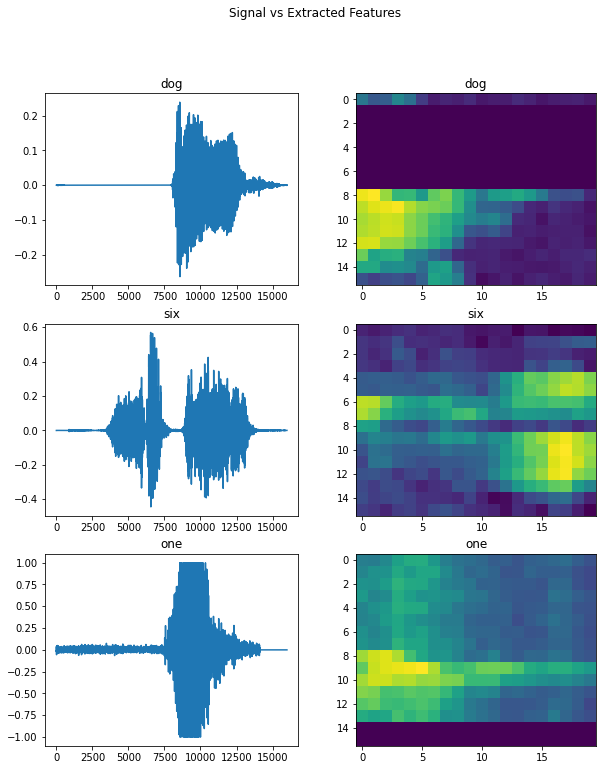

In [115]:
# Visual representation of the source audio and the corresponding features extracted
original_ds = tf.data.Dataset.from_tensor_slices(train).map(get_sample)
feature_ds = configure_data_stream(train)

fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
fig.suptitle('Signal vs Extracted Features')
for idx, ((signal, label),(feature, _)) in enumerate(zip(original_ds.take(3), feature_ds.take(3))):
    ax = axes[idx][0]
    ax.plot(signal.numpy())
    ax.set_title(label.numpy().decode('utf-8'))

    ax = axes[idx][1]
    ax.imshow(feature.numpy())
    ax.set_title(label.numpy().decode('utf-8'))
    

## Set up data streams for the datasets

In [116]:
train_ds = configure_data_stream(train, data_augmentation=True).prefetch(tf.data.experimental.AUTOTUNE).batch(_BATCH_SIZE).repeat(_EPOCHS)

# Cache validation set since it will be used repeatedly and wont change due to any data augmentation
val_ds = configure_data_stream(val).prefetch(tf.data.experimental.AUTOTUNE).batch(_BATCH_SIZE).repeat(_EPOCHS)
val_ds.cache()

# Test samples will be evaluated individually, once only
test_ds = configure_data_stream(test).batch(1)

## Set up and train the model

In [102]:
# Set up model
for feature, label in train_ds.take(1):
    input_shape = feature.shape

model = models.Sequential([
    layers.Input((input_shape[1], input_shape[2], input_shape[3])),
    layers.Conv2D(16, 4, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(_DROPOUT),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(_DROPOUT),
    layers.Dense(len(_WORDS), activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'],
)

model.summary()


# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    _PATH_TO_MODEL, save_best_only=True, monitor='val_loss', mode='min')

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-5, mode='min')

early_stopping = callbacks.EarlyStopping(verbose=1, patience=3)

tensorboard = callbacks.TensorBoard(
    log_dir=_PATH_TO_RESULTS+'/logs', histogram_freq=1)


history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=_EPOCHS,
    steps_per_epoch=int(train_samples/_BATCH_SIZE),
    validation_steps=int(val_samples/_BATCH_SIZE),
    callbacks=[checkpoint, reduce_lr, early_stopping, tensorboard])

(100, 16, 20, 1)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 13, 17, 16)        272       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 11, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 5, 7, 32)          0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 6, 64)          8256      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 2, 3, 64)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 2, 3, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 3

INFO:tensorflow:Assets written to: /home/marcus/Documents/Projects/Speech-Recognition/results/model/assets

Evaluating model on test set...
10822/10822 [==============================] - 9s 835us/step - loss: 0.4575 - acc: 0.8528


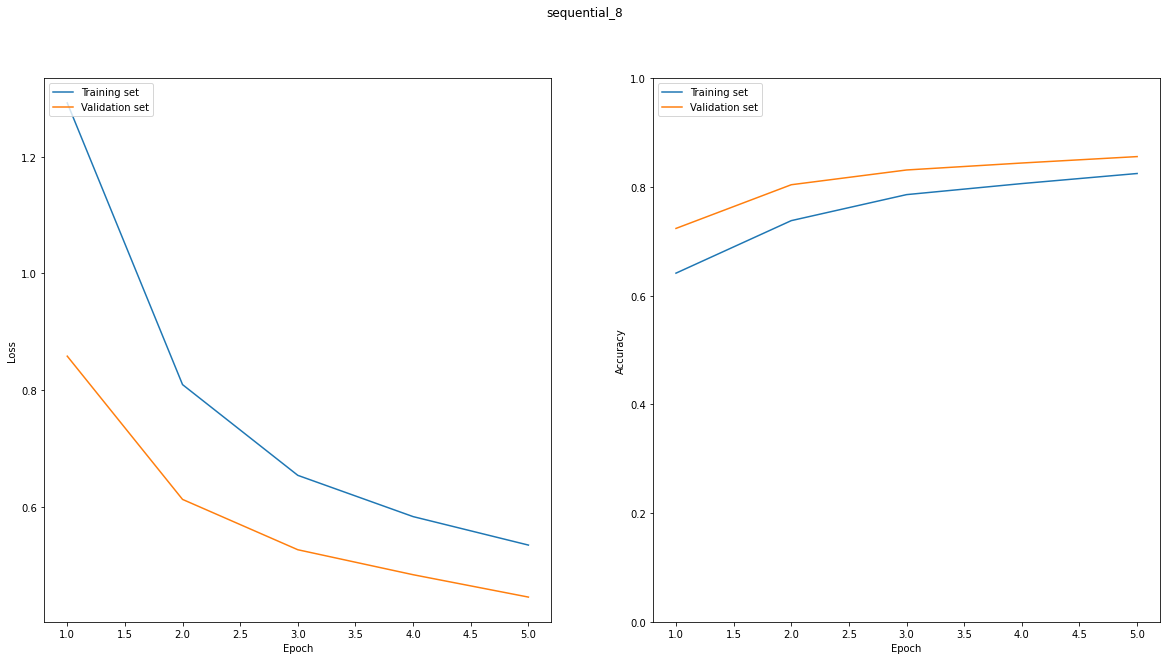

In [103]:
tf.saved_model.save(model, _PATH_TO_MODEL)


# Plot results
plt.figure(figsize=(20.0, 10.0))
plt.suptitle('{}'.format(model.name))
plt.subplot(1, 2, 1, label='Loss plot')
plt.plot(np.arange(1, len(history.history['loss'])+1), history.history['loss'])
plt.plot(
    np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.subplot(1, 2, 2, label='Accuracy plot')
plt.plot(np.arange(
    1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(
    1, len(history.history['val_acc'])+1), history.history['val_acc'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.savefig(_PATH_TO_RESULTS+'/images/training_process.png')


print('\nEvaluating model on test set...')
predictions = model.evaluate(test_ds, verbose=1)
